1. Setup and imports

In [18]:
import sys, importlib
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path().resolve().parent
sys.path.append(str(ROOT))

In [19]:
# libs do projeto 
import src.climate_baselines as cb
import src.hw_detect_inmet as hw_inmet
import src.hw_detect_ouzeau as hw_ouzeau
import src.events_utils as evu

In [20]:
import importlib
from src.events_metrics import Thresholds, compute_event_metrics, expand_event_metrics_to_timeseries
import src.events_metrics as em
importlib.reload(em)

<module 'src.events_metrics' from 'G:\\Meu Drive\\UFSC\\UFSC - Doutorado\\3 HW Detection methods\\1 Desenvolvimento - Pipeline\\src\\events_metrics.py'>

In [21]:
importlib.reload(cb); importlib.reload(hw_inmet); importlib.reload(hw_ouzeau); importlib.reload(evu)

<module 'src.events_utils' from 'G:\\Meu Drive\\UFSC\\UFSC - Doutorado\\3 HW Detection methods\\1 Desenvolvimento - Pipeline\\src\\events_utils.py'>

2. Site parameters and path

In [22]:
SITE_ID = "BSB" 
INTERIM_DIR = ROOT / "data" / "interim" / SITE_ID
PROC_DIR = ROOT / "data" / "processed" / SITE_ID
PROC_DIR.mkdir(parents=True, exist_ok=True)

# Baseline climatológica (fixa) para comparabilidade
BASELINE = ("1991-01-01", "2020-12-31")

RAW_CSV = INTERIM_DIR / "met_raw.csv.gz"   # gerado no 0_ingest_epw.ipynb
DAILY_CSV = INTERIM_DIR / "met_daily.csv.gz"  # opcional; recalculamos abaixo mesmo se não existir

3. Load the datasets

In [23]:
# Série completa com TODAS as variáveis (UTC naive em timeset)
df = pd.read_csv(RAW_CSV, parse_dates=["timeset"])
df = df.sort_values("timeset").reset_index(drop=True)
df["site_id"] = df["site_id"].astype("string")

# séries diárias a partir do raw (Tmax e T̄ de Ta)
daily = (df.set_index("timeset")
           .resample("D")
           .agg(tmax_c=("ta_c", "max"),
                tmean_c=("ta_c", "mean"))
           .reset_index())
daily["site_id"] = SITE_ID

display(df.head(3))
display(daily.head(3))

,site_id,timeset,year,month,day,hour,ta_c,tdp_c,rh_pct,p_atm_pa,...,latitude,longitude,elevation_m,scenario_category,scenario_horizon,scenario_rcp,period_start,period_end,epw_tz_offset_h,epw_tz_label
0,BSB,1991-01-01 01:00:00,1991,1,1,1,19.2,16.8,86,89311,...,-15.863,-47.913,1060.4,historical,NaN,NaN,1991,2023,-3.0,UTC-3
1,BSB,1991-01-01 02:00:00,1991,1,1,2,19.0,17.0,88,89635,...,-15.863,-47.913,1060.4,historical,NaN,NaN,1991,2023,-3.0,UTC-3
2,BSB,1991-01-01 03:00:00,1991,1,1,3,19.0,17.0,88,89635,...,-15.863,-47.913,1060.4,historical,NaN,NaN,1991,2023,-3.0,UTC-3


,timeset,tmax_c,tmean_c,site_id
0,1991-01-01,27.0,21.365217,BSB
1,1991-01-02,27.1,22.133333,BSB
2,1991-01-03,30.0,23.587500,BSB


4. Climatological normals (INMET) and thresholds (Ouzeau)

In [24]:
# Normais mensais de Tmax (INMET/WMO) na baseline
daily_max = daily[["timeset", "tmax_c"]].dropna()
normals_m = cb.monthly_normals_tmax(daily_max.rename(columns={"tmax_c": "tmax_c"}),
                                    baseline=BASELINE)

# Percentis Ouzeau de T̄ diária (baseline)
daily_mean = daily[["timeset", "tmean_c"]].dropna()
ouz_thr = cb.ouzeau_thresholds_tmean(daily_mean, baseline=BASELINE)

normals_m, ouz_thr


(    month  normal_tmax_c
 0       1      27.820903
 1       2      28.078561
 2       3      27.848720
 3       4      27.834100
 4       5      26.973871
 5       6      26.268389
 6       7      26.449258
 7       8      28.168419
 8       9      29.820233
 9      10      29.712538
 10     11      27.735422
 11     12      27.599677,
 {'spic': np.float64(27.100895833333333),
  'sdeb': np.float64(25.925312499999997),
  'sint': np.float64(25.28333333333333)})

5. Events detection (INMET)

In [25]:
# Detecta eventos INMET (>= 2 dias acima da normal mensal + Δ=5°C)
events_inmet, inmet_flags_daily = hw_inmet.detect_inmet_events(
    daily_max_df=daily_max.rename(columns={"tmax_c":"tmax_c"}),
    normals_m=normals_m,
    site_id=SITE_ID,
    delta=5.0,
)

In [26]:
# Padroniza, anexa metadados e IDs
ev_inmet_std = evu.standardize_events(
    events_inmet,
    site_id=SITE_ID,
    method="INMET",
    method_version="INMET-1.0",
    baseline=BASELINE,
    threshold_info={"delta_c": 5.0, "normals": "1991-2020"},
    add_level_by_duration=True,   # define nível Yellow/Orange/Red por duração
)
ev_inmet_std = evu.attach_event_id(ev_inmet_std, site_id=SITE_ID, method="INMET")

display(ev_inmet_std)

,start,end,duration_d,peak_c,method,site_id,level,method_version,baseline_start,baseline_end,threshold_info,hw_id
0,1993-03-10,1993-03-11,2,33.0,INMET,BSB,Yellow,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",BSB-INMET-19930310-001
1,1993-11-01,1993-11-02,2,34.0,INMET,BSB,Yellow,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",BSB-INMET-19931101-002
2,1994-11-06,1994-11-08,3,34.0,INMET,BSB,Orange,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",BSB-INMET-19941106-001
3,1997-11-03,1997-11-08,6,34.0,INMET,BSB,Red,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",BSB-INMET-19971103-001
4,1998-01-03,1998-01-05,3,33.0,INMET,BSB,Orange,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",BSB-INMET-19980103-001
5,2002-12-02,2002-12-06,5,34.0,INMET,BSB,Red,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",BSB-INMET-20021202-001
6,2004-09-29,2004-09-30,2,35.0,INMET,BSB,Yellow,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",BSB-INMET-20040929-001
7,2008-11-04,2008-11-05,2,33.0,INMET,BSB,Yellow,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",BSB-INMET-20081104-001
8,2014-10-15,2014-10-19,5,36.0,INMET,BSB,Red,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",BSB-INMET-20141015-001
9,2015-10-17,2015-10-18,2,35.0,INMET,BSB,Yellow,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",BSB-INMET-20151017-001


6. Events detection (Ouzeau)

In [27]:
# Detecta eventos Ouzeau (Spic/Sdeb/Sint sobre T̄ diária)
events_ouz, ouz_flags_daily = hw_ouzeau.detect_ouzeau_events(
    daily_mean_df=daily_mean.rename(columns={"tmean_c":"tmean_c"}),
    thresholds=ouz_thr,
    site_id=SITE_ID,
    n_consecutive=3,  # ajuste se quiser 5
)


In [28]:
# Padroniza e IDs
ev_ouz_std = evu.standardize_events(
    events_ouz,
    site_id=SITE_ID,
    method="Ouzeau",
    method_version="OUZ-2016-v1",
    baseline=BASELINE,
    threshold_info={"spic": float(ouz_thr["spic"]),
                    "sdeb": float(ouz_thr["sdeb"]),
                    "sint": float(ouz_thr["sint"]),
                    "baseline": "1991-2020"},
    add_level_by_duration=False,  # nível é opcional no Ouzeau; se quiser, mude para True
)
ev_ouz_std = evu.attach_event_id(ev_ouz_std, site_id=SITE_ID, method="Ouzeau")

display(ev_ouz_std)

,start,end,duration_d,peak_c,method,site_id,method_version,baseline_start,baseline_end,threshold_info,level,hw_id
0,1997-10-13,1997-10-17,5,27.104167,Ouzeau,BSB,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 27.100895833333333, 'sdeb': 25.925312...",,BSB-Ouzeau-19971013-001
1,1998-10-04,1998-10-08,5,27.470833,Ouzeau,BSB,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 27.100895833333333, 'sdeb': 25.925312...",,BSB-Ouzeau-19981004-001
2,2000-08-26,2000-08-29,4,27.695833,Ouzeau,BSB,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 27.100895833333333, 'sdeb': 25.925312...",,BSB-Ouzeau-20000826-001
3,2000-10-13,2000-10-24,12,27.412500,Ouzeau,BSB,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 27.100895833333333, 'sdeb': 25.925312...",,BSB-Ouzeau-20001013-002
4,2000-10-26,2000-10-28,3,27.283333,Ouzeau,BSB,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 27.100895833333333, 'sdeb': 25.925312...",,BSB-Ouzeau-20001026-003
5,2002-11-29,2002-12-07,9,27.641667,Ouzeau,BSB,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 27.100895833333333, 'sdeb': 25.925312...",,BSB-Ouzeau-20021129-001
6,2004-09-29,2004-10-03,5,28.070833,Ouzeau,BSB,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 27.100895833333333, 'sdeb': 25.925312...",,BSB-Ouzeau-20040929-001
7,2004-10-14,2004-10-19,6,27.637500,Ouzeau,BSB,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 27.100895833333333, 'sdeb': 25.925312...",,BSB-Ouzeau-20041014-002
8,2007-10-28,2007-11-01,5,27.279167,Ouzeau,BSB,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 27.100895833333333, 'sdeb': 25.925312...",,BSB-Ouzeau-20071028-001
9,2008-10-28,2008-10-30,3,27.787500,Ouzeau,BSB,OUZ-2016-v1,1991-01-01,2020-12-31,"{'spic': 27.100895833333333, 'sdeb': 25.925312...",,BSB-Ouzeau-20081028-001


7. Events consolidations and CSV outputs

In [29]:
events_all = pd.concat([ev_inmet_std, ev_ouz_std], ignore_index=True)
events_all = events_all.sort_values(["method","start"]).reset_index(drop=True)

# Salvar eventos por método + consolidado
ev_inmet_std.to_csv(PROC_DIR / "events_inmet.csv", index=False)
ev_ouz_std.to_csv(PROC_DIR / "events_ouzeau.csv", index=False)
events_all.to_csv(PROC_DIR / "events_all.csv", index=False)

events_all.head(10)

,start,end,duration_d,peak_c,method,site_id,level,method_version,baseline_start,baseline_end,threshold_info,hw_id
0,1993-03-10,1993-03-11,2,33.0,INMET,BSB,Yellow,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",BSB-INMET-19930310-001
1,1993-11-01,1993-11-02,2,34.0,INMET,BSB,Yellow,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",BSB-INMET-19931101-002
2,1994-11-06,1994-11-08,3,34.0,INMET,BSB,Orange,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",BSB-INMET-19941106-001
3,1997-11-03,1997-11-08,6,34.0,INMET,BSB,Red,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",BSB-INMET-19971103-001
4,1998-01-03,1998-01-05,3,33.0,INMET,BSB,Orange,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",BSB-INMET-19980103-001
5,2002-12-02,2002-12-06,5,34.0,INMET,BSB,Red,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",BSB-INMET-20021202-001
6,2004-09-29,2004-09-30,2,35.0,INMET,BSB,Yellow,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",BSB-INMET-20040929-001
7,2008-11-04,2008-11-05,2,33.0,INMET,BSB,Yellow,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",BSB-INMET-20081104-001
8,2014-10-15,2014-10-19,5,36.0,INMET,BSB,Red,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",BSB-INMET-20141015-001
9,2015-10-17,2015-10-18,2,35.0,INMET,BSB,Yellow,INMET-1.0,1991-01-01,2020-12-31,"{'delta_c': 5.0, 'normals': '1991-2020'}",BSB-INMET-20151017-001


8. Full dataframe with flags

In [30]:
timeline = df[["timeset"]].copy()
flags_inmet = evu.flags_from_events(events_all, timeline, method="INMET",  col_name="HW_INMET_bool")
flags_ouz   = evu.flags_from_events(events_all, timeline, method="Ouzeau", col_name="HW_OU_bool")

df_flags = timeline.merge(flags_inmet, on="timeset", how="left").merge(flags_ouz, on="timeset", how="left")
df_flags = df_flags.fillna(False)

full_df = df.merge(df_flags, on="timeset", how="left")
full_df["HW_INMET_bool"] = full_df["HW_INMET_bool"].fillna(False)
full_df["HW_OU_bool"]    = full_df["HW_OU_bool"].fillna(False)
full_df["HW_any_bool"]   = full_df["HW_INMET_bool"] | full_df["HW_OU_bool"]
display(full_df.head(3))


,site_id,timeset,year,month,day,hour,ta_c,tdp_c,rh_pct,p_atm_pa,...,scenario_category,scenario_horizon,scenario_rcp,period_start,period_end,epw_tz_offset_h,epw_tz_label,HW_INMET_bool,HW_OU_bool,HW_any_bool
0,BSB,1991-01-01 01:00:00,1991,1,1,1,19.2,16.8,86,89311,...,historical,NaN,NaN,1991,2023,-3.0,UTC-3,False,False,False
1,BSB,1991-01-01 02:00:00,1991,1,1,2,19.0,17.0,88,89635,...,historical,NaN,NaN,1991,2023,-3.0,UTC-3,False,False,False
2,BSB,1991-01-01 03:00:00,1991,1,1,3,19.0,17.0,88,89635,...,historical,NaN,NaN,1991,2023,-3.0,UTC-3,False,False,False


9. Full dataframe CSV export

In [31]:
out_csv = PROC_DIR / "full_timeseries_with_flags.csv.gz"
full_df.to_csv(
    out_csv,
    index=False,
    compression="gzip",
    date_format="%Y-%m-%dT%H:%M:%S",
    float_format="%.6g",
)
out_csv

WindowsPath('G:/Meu Drive/UFSC/UFSC - Doutorado/3 HW Detection methods/1 Desenvolvimento - Pipeline/data/processed/BSB/full_timeseries_with_flags.csv.gz')

10. Quality control

In [32]:
print("Período:", full_df["timeset"].min(), "→", full_df["timeset"].max())
print("Horário total:", len(full_df))

print("\nCobertura de eventos:")
print("INMET: ", full_df["HW_INMET_bool"].mean().round(4), "da série")
print("Ouzeau:", full_df["HW_OU_bool"].mean().round(4), "da série")
print("ANY:   ", full_df["HW_any_bool"].mean().round(4), "da série")

# Conferir algumas janelas com evento
some_evt = events_all.head(1).iloc[0]
mask = (full_df["timeset"] >= some_evt["start"]) & (full_df["timeset"] <= some_evt["end"])
display(full_df.loc[mask, ["timeset","ta_c","HW_INMET_bool","HW_OU_bool"]].head(10))

Período: 1991-01-01 01:00:00 → 2024-01-01 00:00:00
Horário total: 289272

Cobertura de eventos:
INMET:  0.0038 da série
Ouzeau: 0.0153 da série
ANY:    0.0167 da série


,timeset,ta_c,HW_INMET_bool,HW_OU_bool
19175,1993-03-10 00:00:00,23.0,True,False
19176,1993-03-10 01:00:00,21.6,True,False
19177,1993-03-10 02:00:00,21.0,True,False
19178,1993-03-10 03:00:00,20.0,True,False
19179,1993-03-10 04:00:00,19.0,True,False
19180,1993-03-10 05:00:00,19.0,True,False
19181,1993-03-10 06:00:00,18.0,True,False
19182,1993-03-10 07:00:00,17.0,True,False
19183,1993-03-10 08:00:00,18.0,True,False
19184,1993-03-10 09:00:00,20.0,True,False


11. Heatwave characterization

In [33]:
# Séries diárias já criadas no notebook:
#   daily: ['timeset','tmax_c','tmean_c']
dmax  = daily[["timeset","tmax_c"]].dropna().copy()
dmean = daily[["timeset","tmean_c"]].dropna().copy()

# Thresholds (INMET usa normals_m + 5°C; Ouzeau usa Sdeb = P97.5)
thr_inmet = Thresholds(method="INMET", normals_m=normals_m, delta_c=5.0)
thr_ouz   = Thresholds(method="Ouzeau", sdeb_c=float(ouz_thr["sdeb"]))  # Sdeb = 97.5%

# Métricas por evento
ev_inmet_metrics  = compute_event_metrics(ev_inmet_std, dmean, dmax, thr_inmet)
ev_ouzeau_metrics = compute_event_metrics(ev_ouz_std,   dmean, dmax, thr_ouz)

# Propagar para série horária completa
full_plus = expand_event_metrics_to_timeseries(ev_inmet_metrics,  full_df, "INMET")
full_plus = expand_event_metrics_to_timeseries(ev_ouzeau_metrics, full_plus, "OUZ")

# Salvar
PROC_DIR.mkdir(parents=True, exist_ok=True)
(pd.concat([ev_inmet_metrics, ev_ouzeau_metrics], ignore_index=True)
   .sort_values(["method","start"])
   .reset_index(drop=True)
   .to_csv(PROC_DIR / "events_all_with_metrics.csv", index=False))

full_plus.to_csv(PROC_DIR / "full_timeseries_with_flags_and_metrics.csv.gz",
                 index=False, compression="gzip",
                 date_format="%Y-%m-%dT%H:%M:%S", float_format="%.6g")

12. Novo quality control

C:\Users\Matheus\AppData\Local\Temp\ipykernel_15164\4252535588.py:2: DtypeWarning: Columns (54,58,59,63) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FILE, parse_dates=["timeset"]).sort_values("timeset")


Período: 1991-01-01 01:00:00 → 2024-01-01 00:00:00
Total de registros: 289272
Gaps detectados (>1h): 0

Faixas físicas:
             ta_c: 4.90 → 37.00
           rh_pct: 10.00 → 100.00
      wind_spd_ms: 0.00 → 45.20

Cobertura de eventos:
  INMET : 0.56% do período
  Ouzeau: 1.78% do período
  Any   : 1.67% do período

Resumo das métricas (com valores não-nulos):
                          mean       std        min       50%       max
INMET_intensity_c    27.670363  1.007224  25.716700  27.95210  29.19580
INMET_duration_d      3.805970  1.781371   2.000000   3.00000   7.00000
INMET_severity_cday   3.313511  2.689817   0.302559   2.57492   9.85204
OUZ_intensity_c      27.946234  0.580947  27.104200  27.69580  29.19580
OUZ_duration_d        7.948837  3.208177   3.000000   7.00000  15.00000
OUZ_severity_cday     6.851326  4.746636   1.828230   4.78594  18.85600


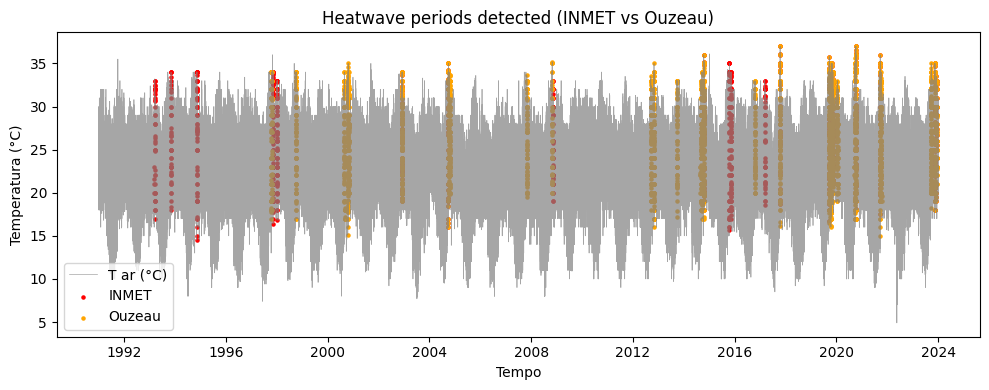

In [34]:
FILE = PROC_DIR / "full_timeseries_with_flags_and_metrics.csv.gz"
df = pd.read_csv(FILE, parse_dates=["timeset"]).sort_values("timeset")

print("Período:", df["timeset"].min(), "→", df["timeset"].max())
print("Total de registros:", len(df))

# === 1. Cobertura temporal ===
df["gap_h"] = (df["timeset"] - df["timeset"].shift()).dt.total_seconds() / 3600
gaps = df[df["gap_h"] > 1]
print(f"Gaps detectados (>1h): {len(gaps)}")

# === 2. Faixas físicas ===
qc_phys = {
    "ta_c": (df["ta_c"].min(), df["ta_c"].max()),
    "rh_pct": (df["rh_pct"].min(), df["rh_pct"].max()),
    "wind_spd_ms": (df["wind_spd_ms"].min(), df["wind_spd_ms"].max()),
}
print("\nFaixas físicas:")
for k, (vmin, vmax) in qc_phys.items():
    print(f"  {k:>15}: {vmin:.2f} → {vmax:.2f}")

# === 3. Cobertura de eventos ===
cov_inmet = df["INMET_hw_id"].notna().mean() * 100
cov_ouz   = df["OUZ_hw_id"].notna().mean() * 100
cov_any   = df["HW_any_bool"].mean() * 100
print(f"\nCobertura de eventos:")
print(f"  INMET : {cov_inmet:.2f}% do período")
print(f"  Ouzeau: {cov_ouz:.2f}% do período")
print(f"  Any   : {cov_any:.2f}% do período")

# === 4. Estatísticas das métricas ===
metrics_cols = ["INMET_intensity_c", "INMET_duration_d", "INMET_severity_cday",
                "OUZ_intensity_c", "OUZ_duration_d", "OUZ_severity_cday"]
print("\nResumo das métricas (com valores não-nulos):")
print(df[metrics_cols].describe().T[["mean", "std", "min", "50%", "max"]])

# === 5. Visualização rápida ===
plt.figure(figsize=(10, 4))
plt.plot(df["timeset"], df["ta_c"], lw=0.5, label="T ar (°C)", color="gray", alpha=0.7)
plt.scatter(df.loc[df["INMET_hw_id"].notna(), "timeset"],
            df.loc[df["INMET_hw_id"].notna(), "ta_c"],
            s=5, color="red", label="INMET")
plt.scatter(df.loc[df["OUZ_hw_id"].notna(), "timeset"],
            df.loc[df["OUZ_hw_id"].notna(), "ta_c"],
            s=5, color="orange", label="Ouzeau")
plt.title("Heatwave periods detected (INMET vs Ouzeau)")
plt.xlabel("Tempo"); plt.ylabel("Temperatura (°C)")
plt.legend()
plt.tight_layout()
plt.show()